# More detailed walkthrough

See the simple walkthrough for a quicker introduction to the PyDDM package. Here, we will go into a little more depth.

<div class="alert alert-block alert-info">
<b>Tip:</b> Before working through this, go through the simple walkthrough.
</div>

## Importing the necessary modules

We will ned to import [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), and [xarray](https://xarray.pydata.org/en/stable/). 
We will also import the [PyDDM](https://rmcgorty.github.io/PyDDM/) package. 

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

from numpy.fft import fft2, ifft2, fftshift
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import tiff_file
import ddm_clean 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

In [3]:
###define SIA functions
def im_corr(image, filter=False, filtersize=80):
    '''
    Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
        
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation
    '''
    
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

def last_3chars(x):
    return((x.split('\\')[-1])[-7:-4])
#last_3chars(files[0])

## Initializing DDM_Analysis class and computing the DDM matrix

In [71]:
###Read YAML file and find tiff to analyzed
import yaml
import pims

yaml_file = "Achiriloaie_activeAMT_1000fr_7.yml"

with open(yaml_file, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
#print(data_loaded)
file_to_load = str(data_loaded['DataDirectory'] + data_loaded['FileName'])+'/'
data_directory = str(data_loaded['DataDirectory'])
filename = str((data_loaded['FileName'])[:-4])
print(filename)

im_array = [0.0]
im_array = tiff_file.imread(file_to_load)
#print("Shape of ims is %i,%i" % im_array.shape)
#plt.matshow(im_array[0])
v = pims.TiffStack(file_to_load)
print(v)
print("total number of frames is " + str(int(len(v))))
print("number of frames to be previewed is " + str(int(len(v)/50)))
#plt.matshow(im_array[900])

Achiriloaie_activeAMT_1000fr_7
<Frames>
Source: /Users/gregor/Downloads/Daisy/Achiriloaie_activeAMT_1000fr_7.tif/
Length: 1000 frames
Frame Shape: (256, 256)
Pixel Datatype: uint16
total number of frames is 1000
number of frames to be previewed is 20


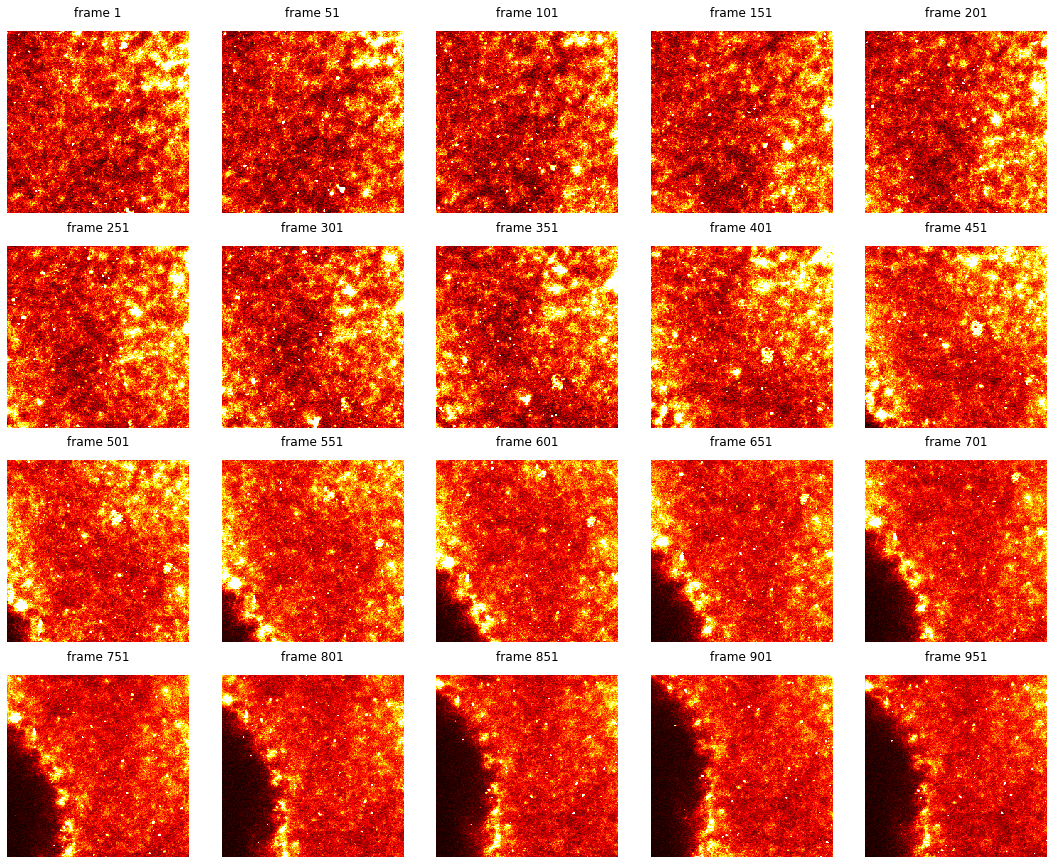

In [30]:
###preview frames that will be analyzed in pre-DDM SIA 
plt.figure(figsize=(15,15)) #Create figure of size 15x15 (inches)

for i in range (int(len(v)/50)):
    ax = plt.subplot(5,5,i+1) 
    ax.set_title("frame %i" % int(i*50 + 1))
    ax.matshow(im_array[i*50], cmap = 'hot') #fig.set_cmap('hot') 
    plt.axis('off')
    plt.tight_layout(pad=.75)

In [31]:
###make arrays to filled with data later on
corr_im_array = [0.0] * int(len(v)/50)
corr_rad_array = [0.0] * int(len(v)/50)
all_xvalues = [0.0] * int(len(v)/50)
curve_fit_array = [[0,0]] * int(len(v)/50)
corr_length_array = [0.0] * int(len(v)/50)
#print(curve_fit_array)
#print(curve_fit_array[1][1])

In [39]:
###define function to find characteristic correlation lengths of SIA curves 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

results_dict = {}

one_over_e = 1.0/np.exp(1) #characteristic decay length 1/e = 0.36787944117144233... 
#print(one_over_e)

(0.18, 30)

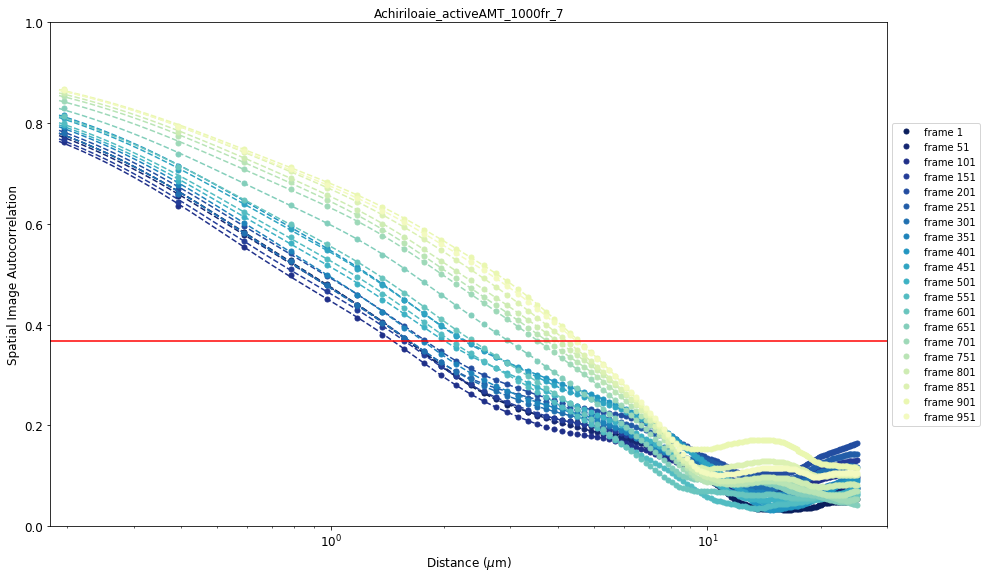

In [72]:
###set figure parameters 
cmap = matplotlib.cm.get_cmap('YlGnBu')
fig, ax = plt.subplots(figsize=(15,15/1.618))
ax.tick_params(axis='both', which='major', labelsize=12)
markerSize = 10

for i in range(int(len(v)/50)):
    ###generate SIA curves for each given frame
    frame_num = "frame %i" % int(i*50 +1) 
    corr_im_array[i], corr_rad_array[i] = im_corr(im_array[i*50],filter=False,filtersize=50)
    xvalues = np.arange(len(corr_rad_array[0]))*0.196 
    y_array = gf1d(corr_rad_array[i],1) #gaussian filter to smooth SIA curves, adjust/use as needed
    plt.semilogx(xvalues, y_array,'.', ms=markerSize, c=cmap(0.99-(i/21)), label=frame_num)
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    fit_line = np.poly1d(np.polyfit(xvalues[:fit_lim], y_array[:fit_lim], 18))
    x_fit_values = np.linspace(0.19, 8, 1000)
    a = fit_line(x_fit_values)
    plt.semilogx(x_fit_values, a,'--',c=cmap(0.99-(i/21)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    nearest = find_nearest(a, one_over_e)
    index, = np.where(a == nearest)
    corr_length = float(x_fit_values[index])
    
    ###saving all data & results to results dictionary 
    results_dict[frame_num] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[frame_num]["x vals"] = xvalues
    results_dict[frame_num]["y vals"] = y_array
    results_dict[frame_num]["x fit vals"] = x_fit_values
    results_dict[frame_num]["y fit vals"] = a
    results_dict[frame_num]["corr length"] = corr_length
    corr_length_array[i] = corr_length
    #plt.axvline(x=corr_length, color='r', linestyle='-')  #option to plot vertical line at correlation length value
    #print(fit_line(x_fit_values))
    
plt.xlabel("Distance ($\mu$m)",fontsize=15)
plt.ylabel("Spatial Image Autocorrelation",fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
plt.title(filename)
plt.ylim(0, 1)
plt.xlim(0.18, 30)

#print(results_dict['frame 1']["y vals"])
#print(corr_length_array)

In [62]:
###save figure 
fig.savefig(data_directory+"SIA curves for "+filename+".jpg")

In [63]:
###this section finds the average intensity value for each frame
from skimage import io, img_as_float

avg_intensity_array = [0.0] * int(len(v)/50)
intensity_std_array = [0.0] * int(len(v)/50)

for i in range(int(len(v)/50)):
    frame_num = "frame %i" % int(i*50 +1)
    image = img_as_float(im_array[i*50])
    avg_intensity_array[i] = np.mean(image)
    intensity_std_array[i] = np.std(image)
    
    ###save these results to results_dict with new keys
    results_dict[frame_num+" -avg intensity"] = np.mean(image)
    results_dict[frame_num+" -intensity std"] = np.std(image)
    
#print(avg_intensity_array)

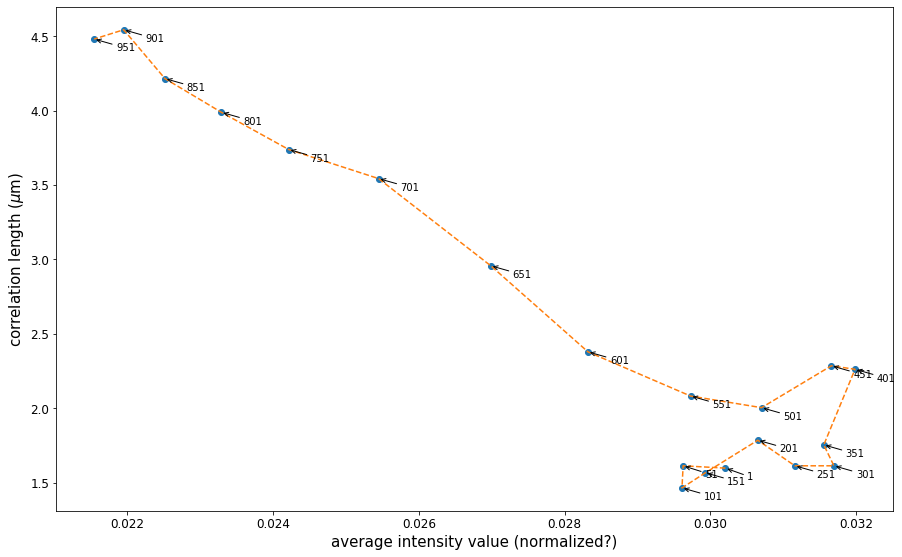

In [76]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(15,15/1.618))
ax.tick_params(axis='both', which='major', labelsize=12)
markerSize = 10

plt.plot(avg_intensity_array, corr_length_array,'o')
plt.plot(avg_intensity_array, corr_length_array,'--')
plt.xlabel("average intensity value (normalized?)",fontsize=15)
plt.ylabel("correlation length ($\mu$m)",fontsize=15)

###label each point 
frame_array = [0] * int(len(v)/50)
for i in range(int(len(v)/50)): 
    frame_array[i] = int(i*50 +1)
    
for i, frame in enumerate(frame_array):
    x = avg_intensity_array[i]
    #x = intensity_std_array[i]
    y = corr_length_array[i]
    x2 = x + 0.0003          ###adjust these numbers to offset frame number labels from the data points 
    y2 = y - 0.08            ### (if you don't see arrows, increase these, if you see error messages, decrease these)
    ax.annotate(frame, xy=(x, y),xycoords='data', xytext=(x2, y2), arrowprops=dict(arrowstyle="->", color='black'))

In [66]:
###save figure 
fig.savefig(data_directory+"avg intensity vs correlation length for "+filename+".jpg")

Text(0, 0.5, 'correlation length ($\\mu$m)')

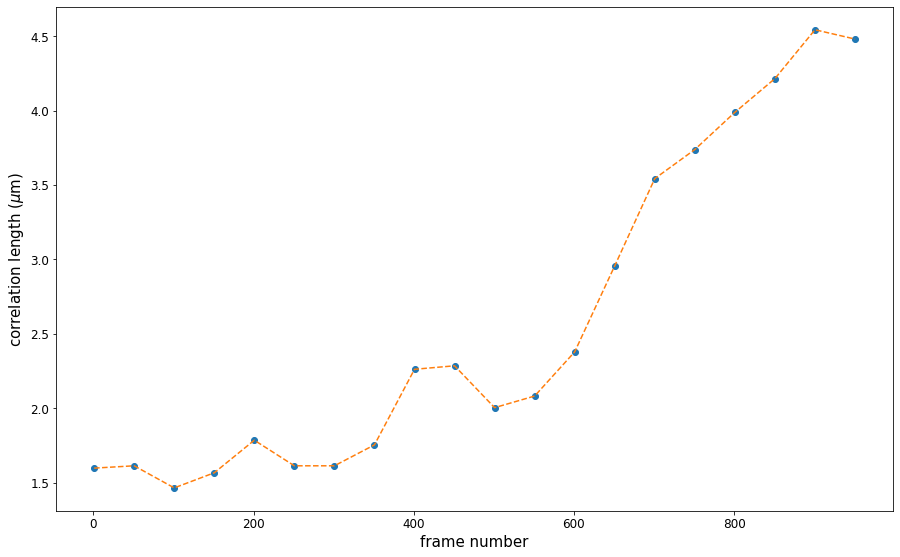

In [77]:
fig, ax = plt.subplots(figsize=(15,15/1.618))
ax.tick_params(axis='both', which='major', labelsize=12)
markerSize = 10

plt.plot(frame_array, corr_length_array,'o')
plt.plot(frame_array, corr_length_array,'--')
plt.xlabel("frame number",fontsize=15)
plt.ylabel("correlation length ($\mu$m)",fontsize=15)

In [ ]:
###save figure 
fig.savefig(data_directory+"frame number vs correlation length for "+filename+".jpg")

In [68]:
###save dictionary results 
file_to_write = open(data_directory+ "DDM -SIA results for "+filename+".p", "wb")
pickle.dump(results_dict, file_to_write)

#print(results_dict)

In [3]:
#The yaml file `example_data_silica_beads.yml` contains the metadata and parameters above

ddm_calc = ddm.DDM_Analysis(yaml_file)d

Provided metadata: {'pixel_size': 0.81, 'frame_rate': 2.65}
Image shape: 1000-by-256-by-256
Number of frames to use for analysis: 999
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Applying binning...
Dimensions after binning (999, 128, 128), the new pixel size 1.62


Below, with the method `calculate_DDM_matrix`, we compute the DDM matrix and some associated data. The data will be stored as an [xarray Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) as an attribute to `ddm_calc` called `ddm_dataset`.

**Note**: There are a few optional arguments we can pass to `calculate_DDM_matrix`. There is an optional argument `quiet` (*True* or *False*, *False* by default). Then we have some optional keyword arguments (all of which could also be specified in the YAML file). These are: `overlap_method` which sets the degree of overlap between image pairs when finding all image differences for a each lag time and is either *0*, *1*, *2*, or *3*, `background_method` which sets how to estimate the background parameter *B* and is either *0*, *1*, *2*, or *3*, and `number_lag_times`. If any of these three keyword arguments are set here, the value specified in the YAML file will be overwritten. 

2022-07-29 10:05:00,533 - DDM Calculations - Running dt = 1...
2022-07-29 10:05:02,338 - DDM Calculations - Running dt = 5...
2022-07-29 10:05:03,428 - DDM Calculations - Running dt = 9...
2022-07-29 10:05:04,290 - DDM Calculations - Running dt = 16...
2022-07-29 10:05:04,943 - DDM Calculations - Running dt = 27...
2022-07-29 10:05:05,483 - DDM Calculations - Running dt = 47...
2022-07-29 10:05:05,944 - DDM Calculations - Running dt = 81...
2022-07-29 10:05:06,383 - DDM Calculations - Running dt = 138...
2022-07-29 10:05:06,764 - DDM Calculations - Running dt = 236...
2022-07-29 10:05:07,092 - DDM Calculations - Running dt = 402...


DDM matrix took 6.858425855636597 seconds to compute.
 Background estimate ± std is 7675.66 ± 211.04


<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.3774 0.7547 1.132 ... 198.1 226.4
    framelag          (frames) int64 1 2 3 4 5 6 7 ... 308 352 402 459 525 600
  * q_y               (q_y) float64 -1.939 -1.909 -1.879 ... 1.848 1.879 1.909
  * q_x               (q_x) float64 -1.939 -1.909 -1.879 ... 1.848 1.879 1.909
  * q                 (q) float64 0.0 0.0303 0.0606 0.0909 ... 1.848 1.879 1.909
  * y                 (y) int64 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int64 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 4.168e+03 ... 5.971e+03
    ddm_matrix        (lagtime, q) float64 0.0 2.989e+03 ... 8.758e+03 9.066e+03
    first_image       (y, x) float64 403.8 406.5 368.2 ... 398.2 456.8 297.2
    alignment_factor  (lagtime, q) float64 nan 6.123e-17 ... 0.08874 0.05498
    avg_image_ft      (q) float64 0.0 2.687e+05 3.972e+05 ... 3.757e+03 3.73e+03
    num_pairs_per_dt  (lagtime) int64 998 997 996 498 497 497 ... 7 6 5 4 3 2
    B                 float64 7.676e+03
    B_std             float64 211.0
    Amplitude         (q) float64 -7.676e+03 5.298e+05 ... -161.6 -215.0
    ISF               (lagtime, q) float64 0.0 1.009 1.006 ... 11.46 7.696 7.467
Attributes: (12/25)
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    ...                      ...
    split_into_4_rois:       False
    use_windowing_function:  False
    binning:                 True
    bin_size:                2
    central_angle:           None
    angle_range:             None

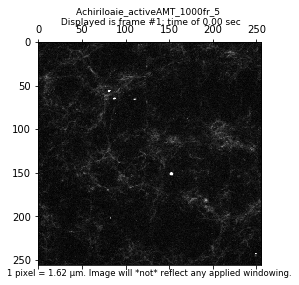

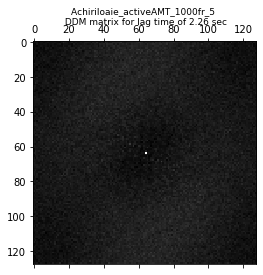

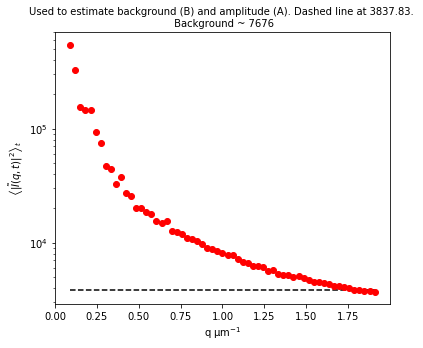

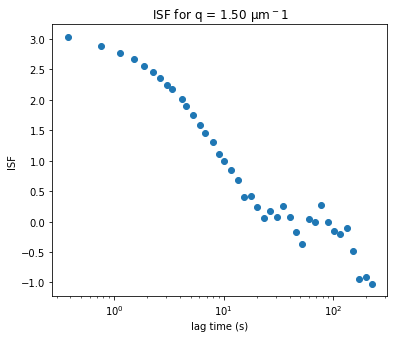

In [4]:
ddm_calc.calculate_DDM_matrix()

### Digging into the DDM xarray.Dataset

Let's look at the dataset created after running `calculate_DDM_matrix`. 

In [4]:
display(ddm_calc.ddm_dataset)

<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
Attributes: (12/24)
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    ...                      ...
    split_into_4_rois:       no
    use_windowing_function:  no
    binning:                 no
    bin_size:                2
    central_angle:           no
    angle_range:             no

In [5]:
print("Notice the data variables: \n", ddm_calc.ddm_dataset.data_vars)

Notice the data variables: 
 Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73


Within this `ddm_datset`, we have the DDM matrix $D(q_x, q_y, \Delta t)$ stored as `ddm_matrix_full`. We can take a look at a slice of this matrix with the `matshow` function in `matplotlib`. 

Text(0.5, 1.0, 'DDM matrix for lag time of 0.288 s')

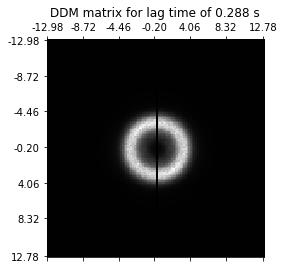

In [6]:
###############################################################
# Displaying a slice of the full three-dimensional DDM matrix #
###############################################################

lagtime_for_ddmmatrix = 10
fig,ax = plt.subplots()
plt.matshow(ddm_calc.ddm_dataset.ddm_matrix_full[lagtime_for_ddmmatrix], fignum=0, cmap='gray')

#Setting up the ticks and tick labels so that they match q_x and q_y
ticks = np.linspace(0,ddm_calc.ddm_dataset.ddm_matrix_full.shape[1]-1,7,dtype=int)
ticklabelsx = ["{:4.2f}".format(i) for i in ddm_calc.ddm_dataset.q_x[ticks].values]
ticklabelsy = ["{:4.2f}".format(i) for i in ddm_calc.ddm_dataset.q_y[ticks].values]
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabelsx)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabelsy)

plt.title("DDM matrix for lag time of %.3f s" % ddm_calc.ddm_dataset.lagtime[10])

The slice of the DDM matrix above looks pretty radially symmetric. This is expected as we are analyzing a video of silica particles diffusing randomly with no preferred direction. Because of this symmetry, we can radially average the DDM matrix to go from $D(q_x, q_y, \Delta t)$ to $D(q, \Delta t)$ where $q = \sqrt{q_x^2 + q_y^2}$. 

Let's plot a slice of this radially averaged DDM matrix $D(q, \Delta t)$ (which is stored as the variable `ddm_matrix` in the `ddm_dataset`).

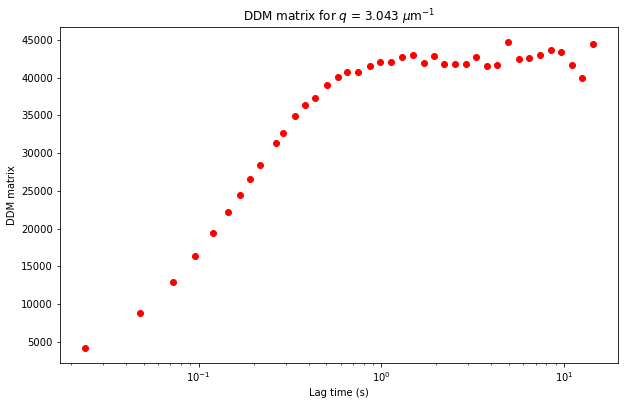

In [7]:
######################################################################
# Plotting the radially averaged DDM matrix for a particular q-value #
######################################################################

q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix[:,q_index], 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for $q$ = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q[q_index]);

#### Different data selecting methods

Since we are slicing this [xarray dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html), let's use the opportunity to go over different ways of selecting data stored in a dataset. See the [xarray user guide](https://xarray.pydata.org/en/stable/user-guide/indexing.html) for more info. 

1. We can use the `isel` function (see [xarray.DataArray.isel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html)). 
```python
q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix.isel(q=q_index), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for q = %.3f " % ddm_calc.ddm_dataset.q[q_index])
```


2. We can select the desired *q* not based on its **index** but on its actual **value** with `sel` (see [xarray.DataArray.sel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html). Note that here we have to use `method = 'nearest'` since we do not have a *q* value of exactly 3 $\mu$m$^{-1}$.
```python
q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix.sel(q=3, method='nearest'), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for q = %.3f " % ddm_calc.ddm_dataset.q[q_index])
```


3. Lastly, we can create this plot (using whichever slicing method) with xarray's plotting function (which just wraps `matplotlib.pyplot`). For more, see [xarray.DataArray.plot](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html).
```python
q_index = 15
ddm_calc.ddm_dataset.ddm_matrix.isel(q=q_index).plot(xscale='log', marker='o', ls='none')
```

#### Determing the A and B parameters to get the ISF

Let's now look at the `avg_image_ft` data variable. This is a radially averaged average of all the Fourier transforms of the images (i.e., the radially average of $\left< | \tilde{I}(q, t) |^2 \right>_t$). This function should equal $ (1/2) \times \left[ A(q) + B(q) \right] $. 

If we make the assumption that at the highest wavevectors (large $q$) the amplitude, $A(q)$, goes to zero, then we can estimate the background, $B$. If we also assume that the background is a constant that's independent of $q$, then we can determine $A(q)$. 

Plotted below is this `avg_image_ft` along with a horizontal line which can be used to estimate **half** the background. This estimate is taken from the last 10% of the wavevectors. The background can be saved to the `B` data variable. And then we can determine the amplitude which is saved as the `Amplitude` variable.

<div class="alert alert-block alert-info">
    <b>Note:</b> What is described above is the <b>default</b> method for getting the background. Other methods can be selected with the optional parameter 'background_method' passed to the method 'calculate_DDM_matrix'.
</div>

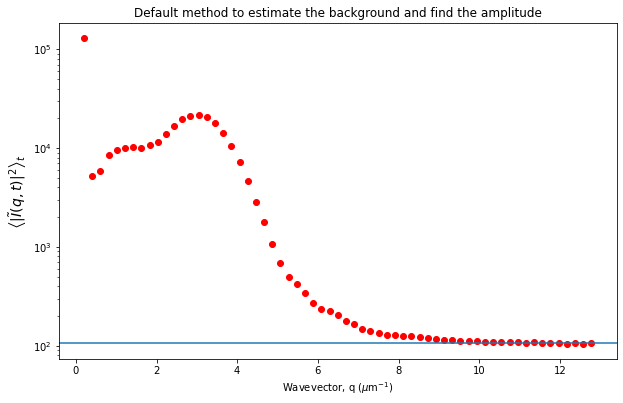

In [8]:
############################################################################################
# Plotting the average squared Fourier-transformed image as a function of the wavevector q #
############################################################################################

plt.figure(figsize=(10,10/1.618))
plt.semilogy(ddm_calc.ddm_dataset.q[1:], ddm_calc.ddm_dataset.avg_image_ft[1:], 'ro')
plt.xlabel("Wavevector, q ($\mu$m$^{-1}$)")
plt.ylabel(r"$\left< | \tilde{I}(q, t) |^2 \right>_t$", fontsize=14)
plt.title("Default method to estimate the background and find the amplitude")

number_of_hi_qs = int(0.1*len(ddm_calc.ddm_dataset.q)) #getting highest 10% of q's
plt.axhline(y = ddm_calc.ddm_dataset.avg_image_ft[-1*number_of_hi_qs:].mean())

The other methods for getting the background (and from the background then estimating the amplitude) are:
* `background_method` = 1: $B$ will be the minimum of the DDM matrix
* `background_method` = 2: $B$ will be the average (over all lag times) of the DDM matrix at the largest wavevector $q$
* `background_method` = 3: $B$ = 0

If we know $A(q)$ and $B$, then we can find the intermediate scattering function, $f(q, \Delta t)$, by assuming that the DDM matrix is equal to $D (q, \Delta t) = A(q) \times \left[ 1 - f(q, \Delta t) \right] + B$. 

The ISF is stored as the data variable `ISF` in the `ddm_dataset`. 

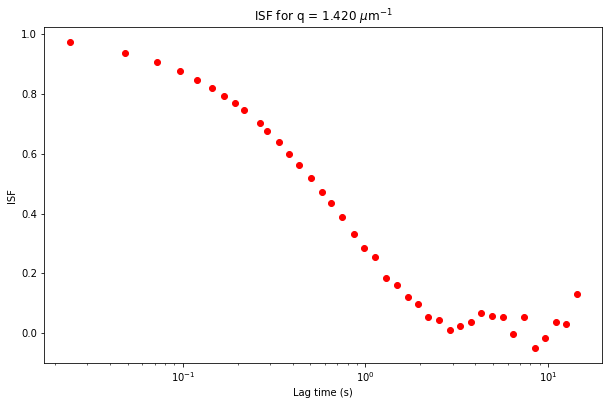

In [9]:
#############################################################################################################
# Plotting the intermediate scattering function (ISF) for a particular value of q as a function of lag time #
#############################################################################################################

plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ISF.sel(q=1.5, method='nearest'), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("ISF")
plt.title("ISF for q = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q.sel(q=1.5, method='nearest'));

#### Checking the background estimate

We expect the ISF to go from 1 to 0. We may not see exactly this behavior in the ISF for all wavevectors. At larger wavevectors, the dynamics might be fast and we might not be taking images fast enough to see the early decay of the ISF. Conversely, at lower wavevectors, the dynamics might be slow and we may not be able to calculate the ISF for large enough lag times to see it decay all the way to zero. Additionally, for non-ergodic dynamics, the ISF may **not** decay to zero but to some value sometimes referred to as the non-ergodicity parameter. 

But another reason that the ISF may not go from 1 to 0 is that we did a poor job in estimating the background, $B$. Using the default method (`background_method = 0`), we try to estimate $B$ by looking at the average Fourier transforms of all the images, radially averaging that, and assuming that the amplitude goes to zero at large wavevectors. But another way to estimate $B$ is to look at the DDM matrix at large wavevectors, as is plotted below. 

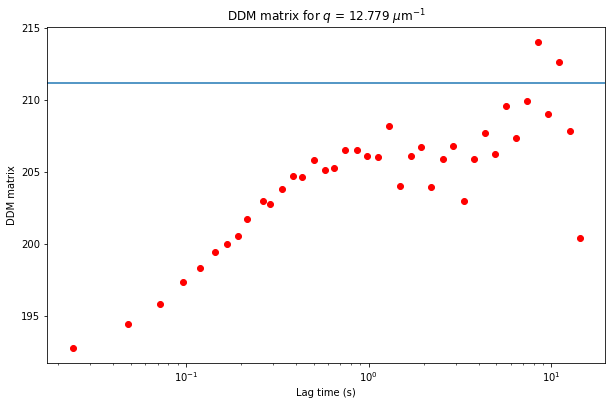

In [10]:
###################################################################################################
# Plotting the radially averaged DDM matrix for the greatest value of q as a function of lag time #
###################################################################################################

q_index = -1 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix[:,q_index], 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for $q$ = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q[q_index]);
plt.axhline(y = ddm_calc.ddm_dataset.B)

The DDM matrix should go from the background, $B$, to the background plus amplitude, $B + A$, as a function of the lag time. From the above plot, it does look like we overestimated the background (perhaps the amplitude hadn't gone quite to zero by the last wavevectors we measure?). From the plot, clearly the background is less than 195. 

Let's estimate the background at  about 190. We can make this adjustment with the `recalculate_ISF_with_new_background` function. 

In [11]:
new_ddm_matrix = ddm.recalculate_ISF_with_new_background(ddm_calc.ddm_dataset, background_val=190)
display(new_ddm_matrix)

<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 int32 190
    B_std             float64 1.491
    Amplitude         (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    ISF               (lagtime, q) float64 0.0 0.9996 0.9872 ... 0.432 0.4966
Attributes: (12/24)
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    ...                      ...
    split_into_4_rois:       no
    use_windowing_function:  no
    binning:                 no
    bin_size:                2
    central_angle:           no
    angle_range:             no

Now let's save this `ddm_dataset`. When the `calculate_DDM_matrix` method is executed, the `ddm_dataset` is automatically saved to disk. But we can overwrite that with the `resave_ddm_dataset` method. 

In [12]:
ddm_calc.resave_ddm_dataset(new_ddm_matrix)

#### Additional notes about the background

The default way that **this** code estimates the background is to compute the power spectrum of the images, as described above. That is, we find $\left< | \tilde{I}(q, t) |^2 \right>_t$ and recognize that $\left< | \tilde{I}(q, t) |^2 \right>_t = 0.5 \times \left[ A(q) + B \right]$ and assume that as $q \rightarrow q_{max}$, $A(q) \rightarrow 0$. Therefore, $\left< | \tilde{I}(q_{max}, t) |^2 \right>_t \approx 0.5\times B$ (see [**Cerbino 2017**] or Eq. 5 in [**Giavazzi 2018**]). 

But, there are other ways. In [**Kurzthaler 2018**], they set the background, $B$, to zero (to do that, use `background_method = 3` as an optional parameter in the function `calculate_DDM_matrix`). They note that for their fluorescence imaging "the camera noise is usually negligible." However, they note that for bright-field of phase contrast modalities, the camera is not negligible and $B$ will be non-zero. 

In [**Bayles 2017**], they approximate $B$ by $\min \left[ D(q, \Delta t_{min}) \right]$. But they note that the frame rate needs to be "sufficiently small" and that this will give an overestimate of $B$. To try this, use `background_method = 1` as an optional keyword parameter in the function `calculate_DDM_matrix` (or set the value of `background_method` in the YAML file under `Analysis_parameters`).


>[**Cerbino 2017**] Cerbino, R., Piotti, D., Buscaglia, M. & Giavazzi, F. [Dark field differential dynamic microscopy enables accurate characterization of the roto-translational dynamics of bacteria and colloidal clusters.](https://doi.org/10.1088/1361-648X/aa9bc5) J. Phys.: Condens. Matter 30, 025901 (2017).

>[**Giavazzi 2018**] Giavazzi, F., Malinverno, C., Scita, G. & Cerbino, R. [Tracking-Free Determination of Single-Cell Displacements and Division Rates in Confluent Monolayers.](https://doi.org/10.3389/fphy.2018.00120) Front. Phys. 6, (2018).

>[**Kurzthaler 2018**] Kurzthaler, C. et al. [Probing the Spatiotemporal Dynamics of Catalytic Janus Particles with Single-Particle Tracking and Differential Dynamic Microscopy.](https://doi.org/10.1103/PhysRevLett.121.078001) Phys. Rev. Lett. 121, 078001 (2018).

>[**Bayles 2017**] Bayles, A. V., Squires, T. M. & Helgeson, M. E. [Probe microrheology without particle tracking by differential dynamic microscopy.](https://doi.org/10.1007/s00397-017-1047-7) Rheol Acta 56, 863–869 (2017).



## Initiazing DDM_Fit class and fitting our data to a model

We initlize the `DDM_Fit` class by passing it the yaml file containing our analysis parameters.

In [13]:
#Note that to initialize the DDM_Fit class we need to pass it the YAML file containing the parameters 
# *or* a dictionary with the same parameters. 

ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


Loading file C:/Users/rmcgorty/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


Based on what was done above in terms of estimating the background, we found that $B$ should be about 190. We use that estimate of the background to determine $A(q)$ and the intermediate scattering function, $f(q,\Delta t)$. We could proceed to then fit the ISF. But here we choose not to. We fit the DDM matrix and have the amplitude and background, $A$ and $B$, be fitting parameters. But we can constrain these parameters based on what we found above. 

In [14]:
#We update the intial guess for the background and the lower and upper bounds
ddm_fit.set_parameter_initial_guess('Background', 190)
ddm_fit.set_parameter_bounds('Background', [10, 220])

Parameter 'Background' set to 190.
Parameter 'Background' lower limit set to 10.
Parameter 'Background' upper limit set to 220.


### Our first attemp at fitting the data

When we execute the fit below, we can use the optional argument `use_A_from_images_as_guess` set to True. This will use the value of $A(q)$ we esimated from the average Fourier tranform of all images and the estimated background. We can further limit the bounds on $A(q)$ with the optional parameter `update_limits_on_A` set to True. This will restrict the range that $A(q)$ can take to be within 10% of the estimated $A(q)$. If we want the bounds to be stricter or looser than 10%, we can change the optional parameter `updated_lims_on_A_fraction` to be something other than 0.1 (the default).

In [15]:
#Note that the method `fit` has many optional parameters

fit01 = ddm_fit.fit(name_fit = 'fit01', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 2.326e+05 ... 0.705 0.7446
    theory           (lagtime, q) float64 10.0 315.0 338.5 ... 206.7 206.8 206.9
    isf_data         (lagtime, q) float64 0.0 0.9996 0.9872 ... 0.432 0.4966
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    B                int32 190
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.6168642315520588
    tau_vs_q_slope:                 [-1.98005917]
    msd_alpha:                      [1.01007082]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               None
    OverlapMethod:                  2

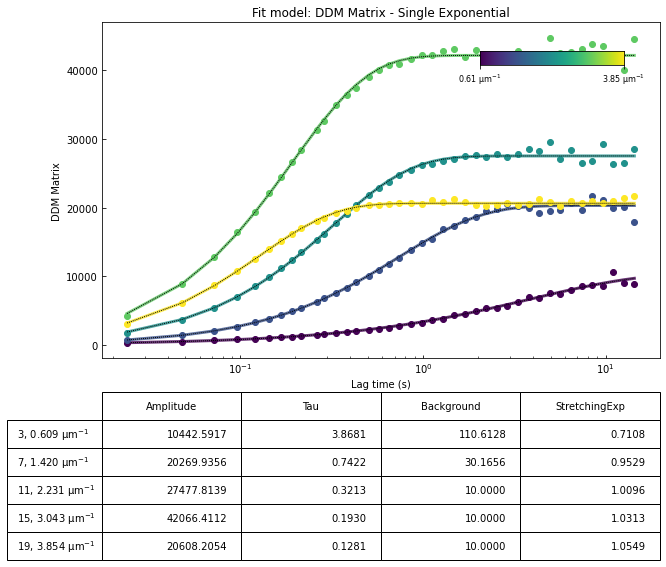

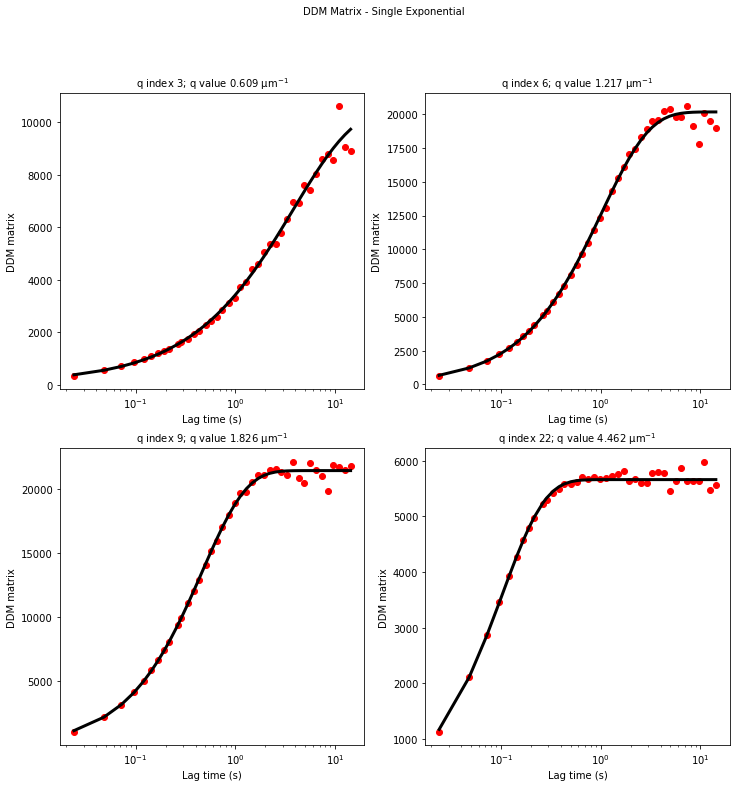

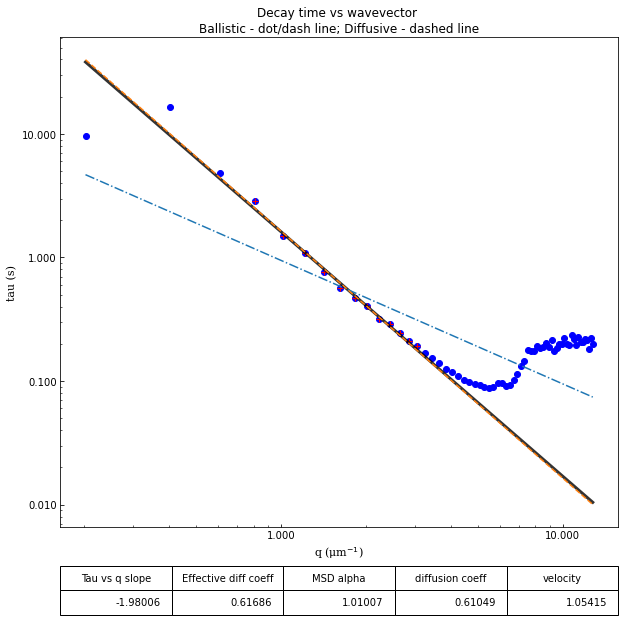

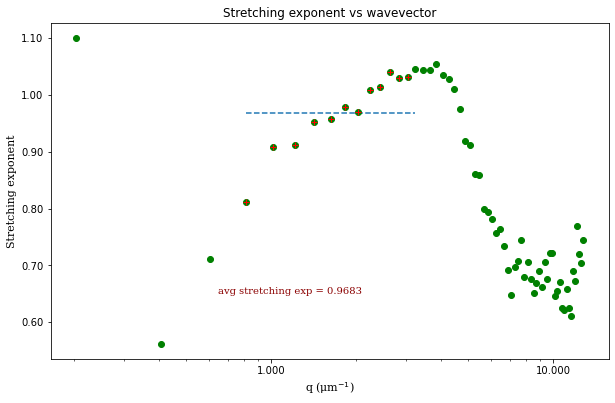

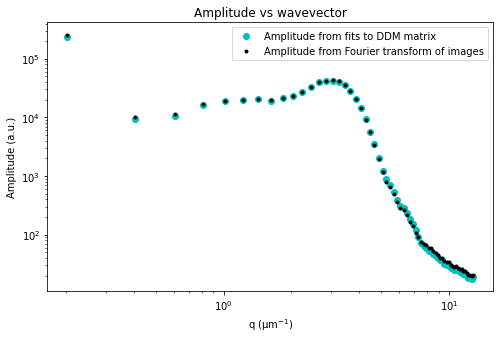

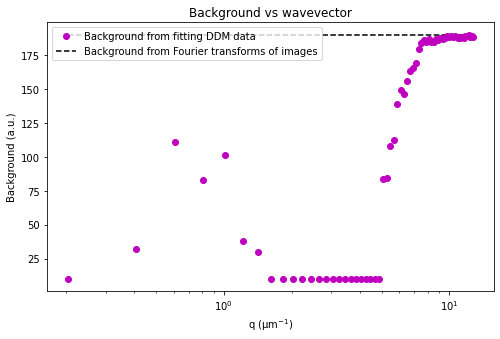

In [16]:
#Generate plots for inspecting the outcome of the fits

ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

### Our second attemp at fitting the data - updating initial guesses for tau

From the results of the fit, we can estimate a diffusion coefficient of about 0.6 $\mu m^2 / s$. We determine this by looking at the characteristic decay time vs the wavevector ($\tau$ vs $q$). On a log-log plot, power laws relationships between the two variables will come across as a straight line where the slope of the line is equal to the power. And, for this data, we see a clear power law show a relationship of $\tau \propto q^{-2}$ which indicates diffusive motion. Note that our data deviates from this power law relationship for $q$ greater than about 4 $\mu m^{-1}$. This could be due to poor optical resolution limiting the high wavevectors (which correspond to small length scales). Or it could be due to not having the temporal resolution necessary to detect fast decay times. Lastly, it could also be due to poor fit performance. We could try to use an initial guess for $\tau$ for each $q$ that is based on an estimated diffusion coefficient. That is, when we fit $D(q, \Delta t)$ (or $f(q,\Delta t)$), for each $q$, we will calculate $\tau_{guess} = 1 / (Dq^2)$ and use that as the initial guess in the fits. We do that below.

In [17]:
fit02 = ddm_fit.fit(name_fit = 'fit02', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True,
                   update_tau_based_on_estimated_diffcoeff=True, estimated_diffcoeff=0.6, 
                   update_limits_on_tau=True, updated_lims_on_tau_fraction=1)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit02'.


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 2.326e+05 9.894e+03 ... 0.5 0.5
    theory           (lagtime, q) float64 10.0 152.4 361.6 ... 202.0 201.7 201.6
    isf_data         (lagtime, q) float64 0.0 0.9996 0.9872 ... 0.432 0.4966
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    B                int32 190
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.6584064996820138
    tau_vs_q_slope:                 [-1.89886818]
    msd_alpha:                      [1.053259]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               None
    OverlapMethod:                  2

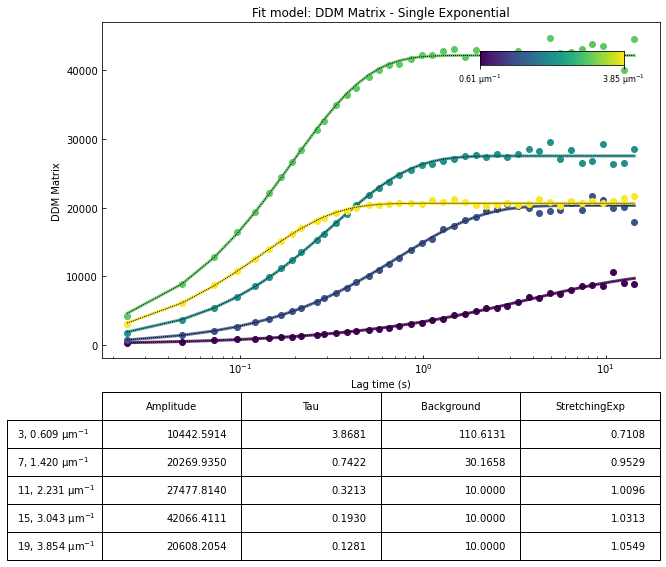

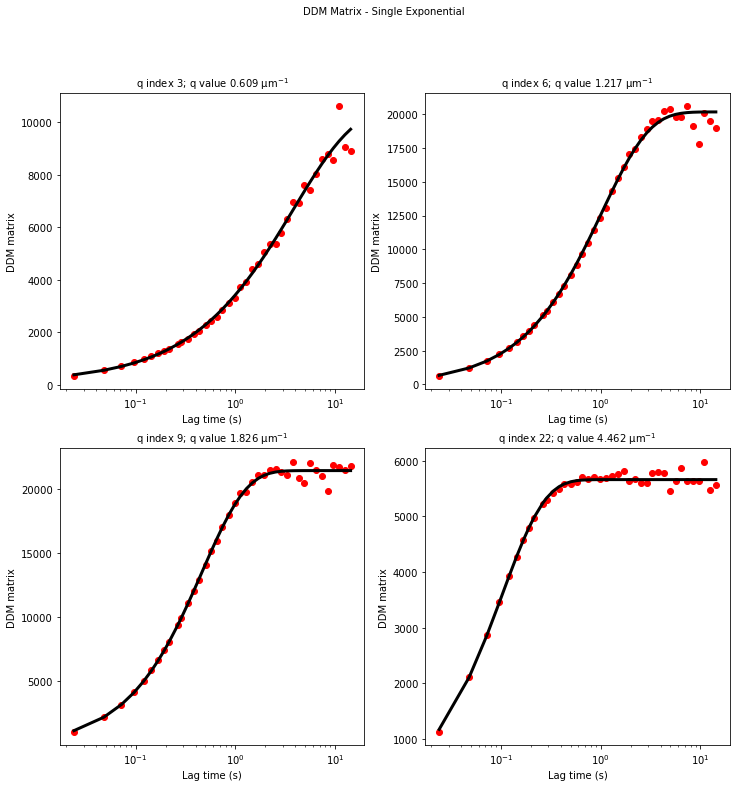

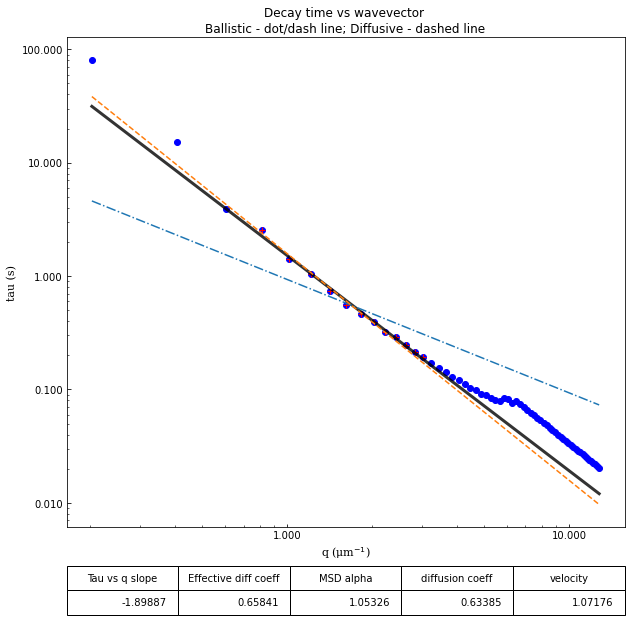

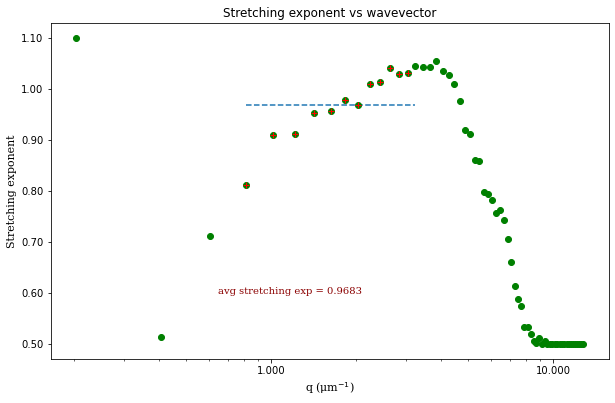

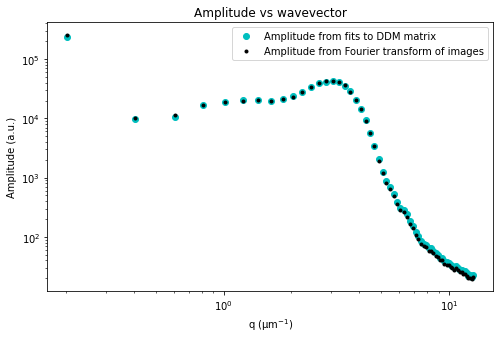

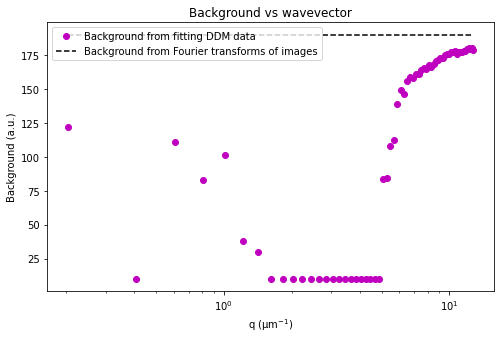

In [18]:
ddm.fit_report(fit02, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=False, show=True)

It doesn't appear that that helped much. In fact, we see that the $\tau$ values appear to be "hitting the rails" of the bounds we imposed on the parameter. 

Below, we plot $\tau$ vs $q$ for the last two fittings. We see that updating the initial guess didn't improve things. So the reason that the $\tau$ found for the high wavevectors is off does not seem to be related to the fitting algorithm using a poor initial guess. Perhaps at the high wavevectors the dynamics are too fast for us detect with the camera frame rate we used? Below we also plot a horizontal line corresponding the time interval between frames. We see that the fits are off even well above our temporal resolution. So it is also not the case that the fits at some of the high wavevectors is due to poor temporal resolution. 

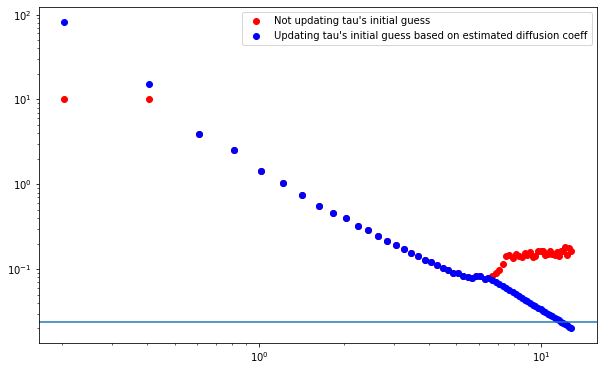

In [19]:
################################################################################################
# Plotting the characteristic decay time tau vs wavevector q determined from the last two fits #
################################################################################################

plt.figure(figsize=(10,10/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'ro', label="Not updating tau's initial guess")
plt.loglog(fit02.q, fit02.parameters.loc['Tau'], 'bo', label="Updating tau's initial guess based on estimated diffusion coeff")
plt.axhline(y = 1.0/fit01.frame_rate)
plt.legend(loc=0)

### Our third attemp at fitting the data - tightening the bounds on the stretching exponent

Let's try one more thing with this fitting. Let's think about the stretching exponent. For normal diffusive motion, we expect the intermediate scattering function to be a simple exponential: $f(q,\Delta t) = \exp(-\Delta t / \tau)$. But sometimes when the dynamics are heterogeneous or subdiffusion is present, we see that a stretched exponential works better. That is, for the ISF we use: $f(q,\Delta t) = \exp(-\Delta t / \tau)^s$ where $s$ is the stretching exponent. 

For this example data, we just have movie of silica colloidal particles diffusing in water. The dynamics should be diffusive. So we could try constraining the stretching exponent to be around to 1 as we expect (notice how the stretching exponent is between 0.6 and 0.7 for the high $q$ values in the previous fits).

In [20]:
#We update the intial guess for the background and the lower and upper bounds
ddm_fit.set_parameter_initial_guess('StretchingExp', 1)
ddm_fit.set_parameter_bounds('StretchingExp', [0.85, 1])

Parameter 'StretchingExp' set to 1.
Parameter 'StretchingExp' lower limit set to 0.85.
Parameter 'StretchingExp' upper limit set to 1.


In [21]:
fit03 = ddm_fit.fit(name_fit = 'fit03', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True,
                   update_tau_based_on_estimated_diffcoeff=True, estimated_diffcoeff=0.6, 
                   update_limits_on_tau=True, updated_lims_on_tau_fraction=1)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit03'.


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 2.326e+05 ... 0.85 0.85
    theory           (lagtime, q) float64 10.0 78.85 304.9 ... 200.8 200.6 200.4
    isf_data         (lagtime, q) float64 0.0 0.9996 0.9872 ... 0.432 0.4966
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    B                int32 190
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.6779463827208101
    tau_vs_q_slope:                 [-1.84532034]
    msd_alpha:                      [1.08382266]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               None
    OverlapMethod:                  2

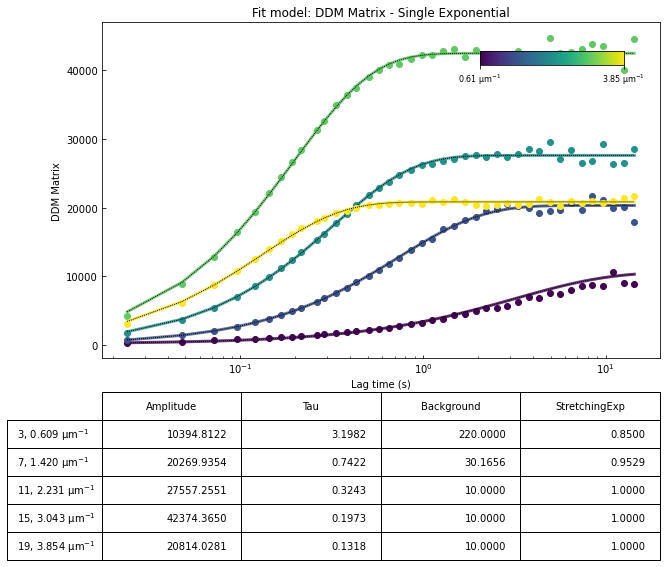

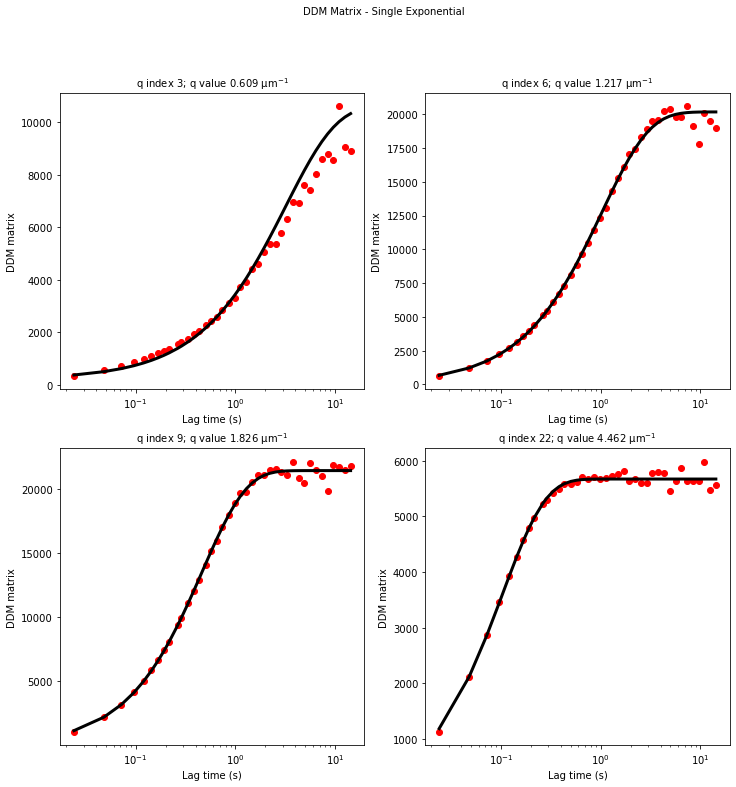

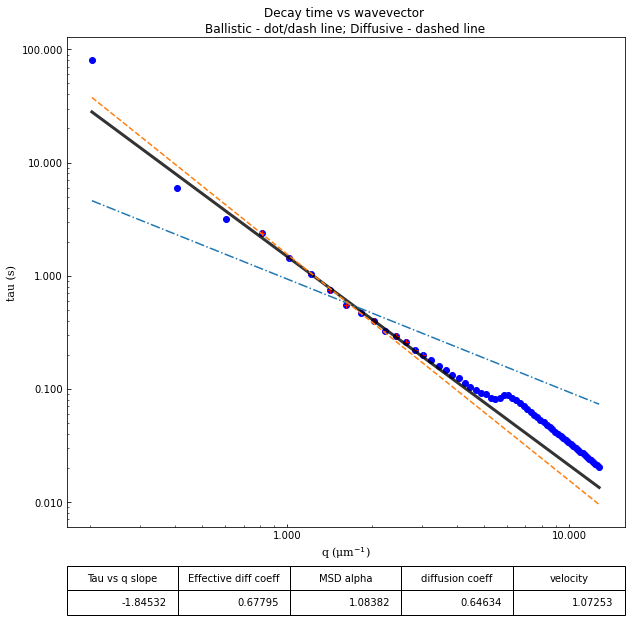

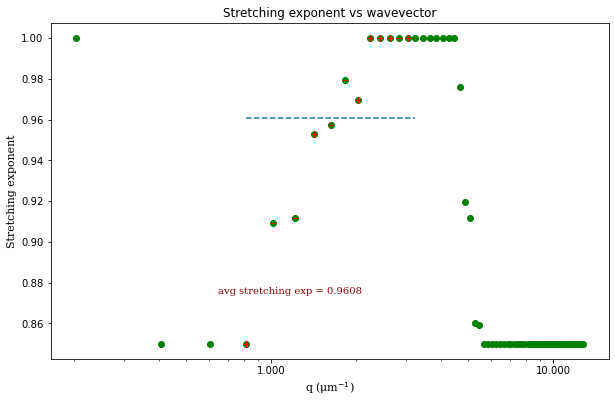

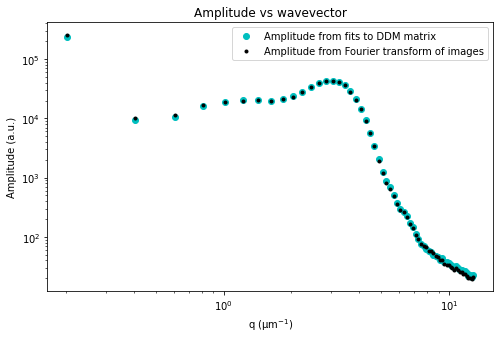

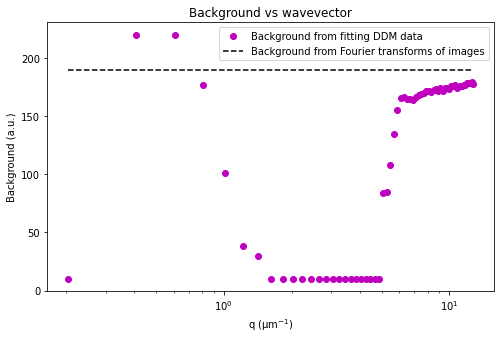

In [22]:
ddm.fit_report(fit03, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=False, show=True)

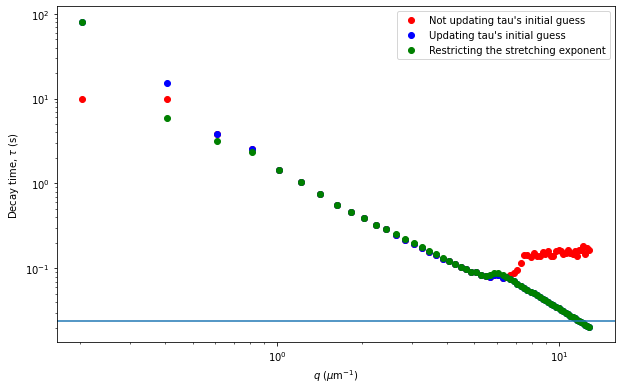

In [23]:
##################################################################################################
# Plotting the characteristic decay time tau vs wavevector q determined from the last three fits #
##################################################################################################

plt.figure(figsize=(10,10/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'ro', label="Not updating tau's initial guess")
plt.loglog(fit02.q, fit02.parameters.loc['Tau'], 'bo', label="Updating tau's initial guess")
plt.loglog(fit03.q, fit03.parameters.loc['Tau'], 'go', label="Restricting the stretching exponent")
plt.xlabel("$q$ ($\mu$m$^{-1})$")
plt.ylabel("Decay time, $\\tau$ (s)")
plt.axhline(y = 1.0/fit01.frame_rate)
plt.legend(loc=0)

### What to make of the results at high $q$

So we have tried a couple things to improve the results of our fits for $q \gtrsim 6 \mu m^{-1}$. We tried:
1. Updating the intial guess for $\tau$ for each $q$ based on an expected diffusion coefficient and constraining the bounds of $\tau$ around that guess. 
2. Narrowing the bounds of the stretching exponent to be close to what we would expect for normal diffusive motion (i.e., near 1). 

But, these didn't seem to make the result for $\tau (q)$ reasonable for the larger $q$ values. So what is going on? 

The horizontal line in the plot above corresponds to the minimum time lag we are measuring (24 ms given our frame rate of 41.7 Hz). So we are not lacking in temporal resolution. 

But what about **spatial resolution**? Even though our pixels are 0.242 $\mu m$ in size doesn't mean that we can truly measure dynamics occurring around such small length scales. 

The data used here was acquired using a not-so-great microscope with a 40x 0.5NA objective and a 0.3NA condenser. Assuming light of a wavelength of 550 nm, that means our theoretical resolution is $\frac{1.22 \times 0.550}{0.5+0.3} = 0.763 \mu m$. Note that this is more than 3 times the pixel size.

As described in [**Safari 2015**], the maximum $q$ is determined either by (1) the pixel size, (2) the smallest distance a particle can be detected moving between two frames given the frame rate, and (3) the smallest resolvable distance given the optical resolution limit. In the case of (3): $q_{max} = \frac{2 \pi NA}{\lambda}$. For our data, that would be $q_{max} = 5.7 \mu m^{-1}$. 

**So it seems we have found the culprit of the poor fitting at large $q$: our limited optical resolution.**

>[**Safari 2015**] Safari, M. S., Vorontsova, M. A., Poling-Skutvik, R., Vekilov, P. G. & Conrad, J. C. [Differential dynamic microscopy of weakly scattering and polydisperse protein-rich clusters.](https://doi.org/10.1103/PhysRevE.92.042712) Phys. Rev. E 92, 042712 (2015).


Text(0.5, 1.0, 'Lines correspond roughly to limits of temporal (horizontal line) and spatial (vertical line) resolution')

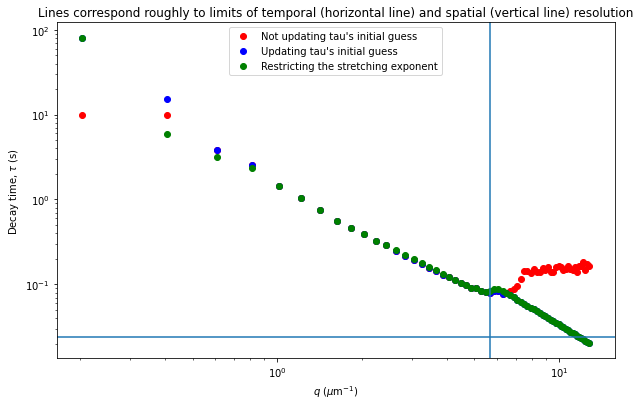

In [24]:
##################################################################################################
# Plotting the characteristic decay time tau vs wavevector q determined from the last three fits #
##################################################################################################

plt.figure(figsize=(10,10/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'ro', label="Not updating tau's initial guess")
plt.loglog(fit02.q, fit02.parameters.loc['Tau'], 'bo', label="Updating tau's initial guess")
plt.loglog(fit03.q, fit03.parameters.loc['Tau'], 'go', label="Restricting the stretching exponent")
plt.xlabel("$q$ ($\mu$m$^{-1})$")
plt.ylabel("Decay time, $\\tau$ (s)")
plt.axhline(y = 1.0/fit01.frame_rate)
plt.axvline(x = 5.7)
plt.legend(loc=0)
plt.title("Lines correspond roughly to limits of temporal (horizontal line) and spatial (vertical line) resolution")

## Determining the mean squared displacement from the ISF

If we assume that the particle displacements are Gaussian, then the ISF can be written as 
$f(q,\Delta t) = \exp \left[ (-q^2 / 4) \left< \Delta r^2(\Delta t) \right> \right]$. We can then find the MSD, $\left< \Delta r^2(\Delta t) \right>$ from the DDM matrix, $D(q, \Delta t)$, using:
$$ \left< \Delta r^2(\Delta t) \right> = \frac{4}{q^2} \ln \left[ \frac{A(q)}{A(q)-D(q,\Delta t)+B(q)} \right]$$

See equation 6 in [**Bayles 2017**] or equation 7 in [**Edera 2017**]. 

We find $\left< \Delta r^2(\Delta t) \right>$ in this code with the method `extract_MSD` in the `DDM_Fit` class. The code will use the *'Amplitude'* and *'Background'* parameters of the fit. But, if those parameters are not present (as would be the case if we fit to the ISF instead of the DDM matrix) then the code will use the estimate for $A(q)$ and $B$ found using  $\left< | \tilde{I}(q, t) |^2 \right>_t$ as described previously in this document.


>[**Bayles 2017**] Bayles, A. V., Squires, T. M. & Helgeson, M. E. [Probe microrheology without particle tracking by differential dynamic microscopy.](https://doi.org/10.1007/s00397-017-1047-7) Rheol Acta 56, 863–869 (2017).

>[**Edera 2017**] Edera, P., Bergamini, D., Trappe, V., Giavazzi, F. & Cerbino, R. [Differential dynamic microscopy microrheology of soft materials: A tracking-free determination of the frequency-dependent loss and storage moduli.](https://doi.org/10.1103/PhysRevMaterials.1.073804) Phys. Rev. Materials 1, 073804 (2017).


C:\Users\rmcgorty\Anaconda3\lib\site-packages\xarray\core\computation.py:742: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Diffusion coefficient: 0.66499 um^2/s


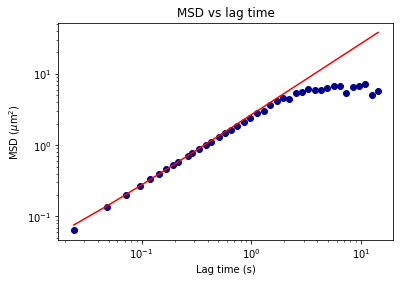

In [25]:
###############################################################################################
# Plotting the mean squared displacement as a function of lag time as determined from the ISF #
###############################################################################################

msd, msd_std = ddm_fit.extract_MSD(fit=fit01)
poly_fit_results = np.polyfit(msd.lagtime[1:10], msd[1:10], 1)

fig,ax = plt.subplots()
plt.loglog(msd.lagtime, msd, 'o', color='darkblue')
plt.plot(msd.lagtime, np.polyval(poly_fit_results,msd.lagtime), '-r')
plt.xlabel("Lag time (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.title("MSD vs lag time")

print(r"Diffusion coefficient: %.5f um^2/s" % (poly_fit_results[0]/4.))